## Testing: choosing a dive, cropping and testing image extraction algorithm

In [51]:
import sys
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import cv2
sys.path.insert(0, '../pipeline')
import extract_SOI_info as soi
import database
import image_extraction as ie
import pandas as pd

#Import JSON file
SOI_dir = soi.SOI_json("../pipeline/tsindex.json")

In [52]:
#Choose a dive, resolution and format of download
soi_dive_id = 'SB0312'
res = 'HD_SIT'
dive_id = soi_dive_id.replace("B", "")  # Remove B from dive_id
dive_path = '../images/' + dive_id + '/'
format="JPEG1080"

#Find seconds when SOI data is not available
frames_NA = SOI_dir.find_frames_NA(dive_id = soi_dive_id, resolution = res)
frames = SOI_dir.find_frames_available(dive_id = soi_dive_id, resolution = res)
print('Length of vid (in seconds):', SOI_dir.vid_minmax(soi_dive_id, resolution = res)['length'])
print('Num of frames where vid is available', len(frames))
print('Num of frames where vid is NA:', len(frames_NA))

Length of vid (in seconds): 35621
Num of frames where vid is available 31435
Num of frames where vid is NA: 4184


### Viewing and crop first frame of dive

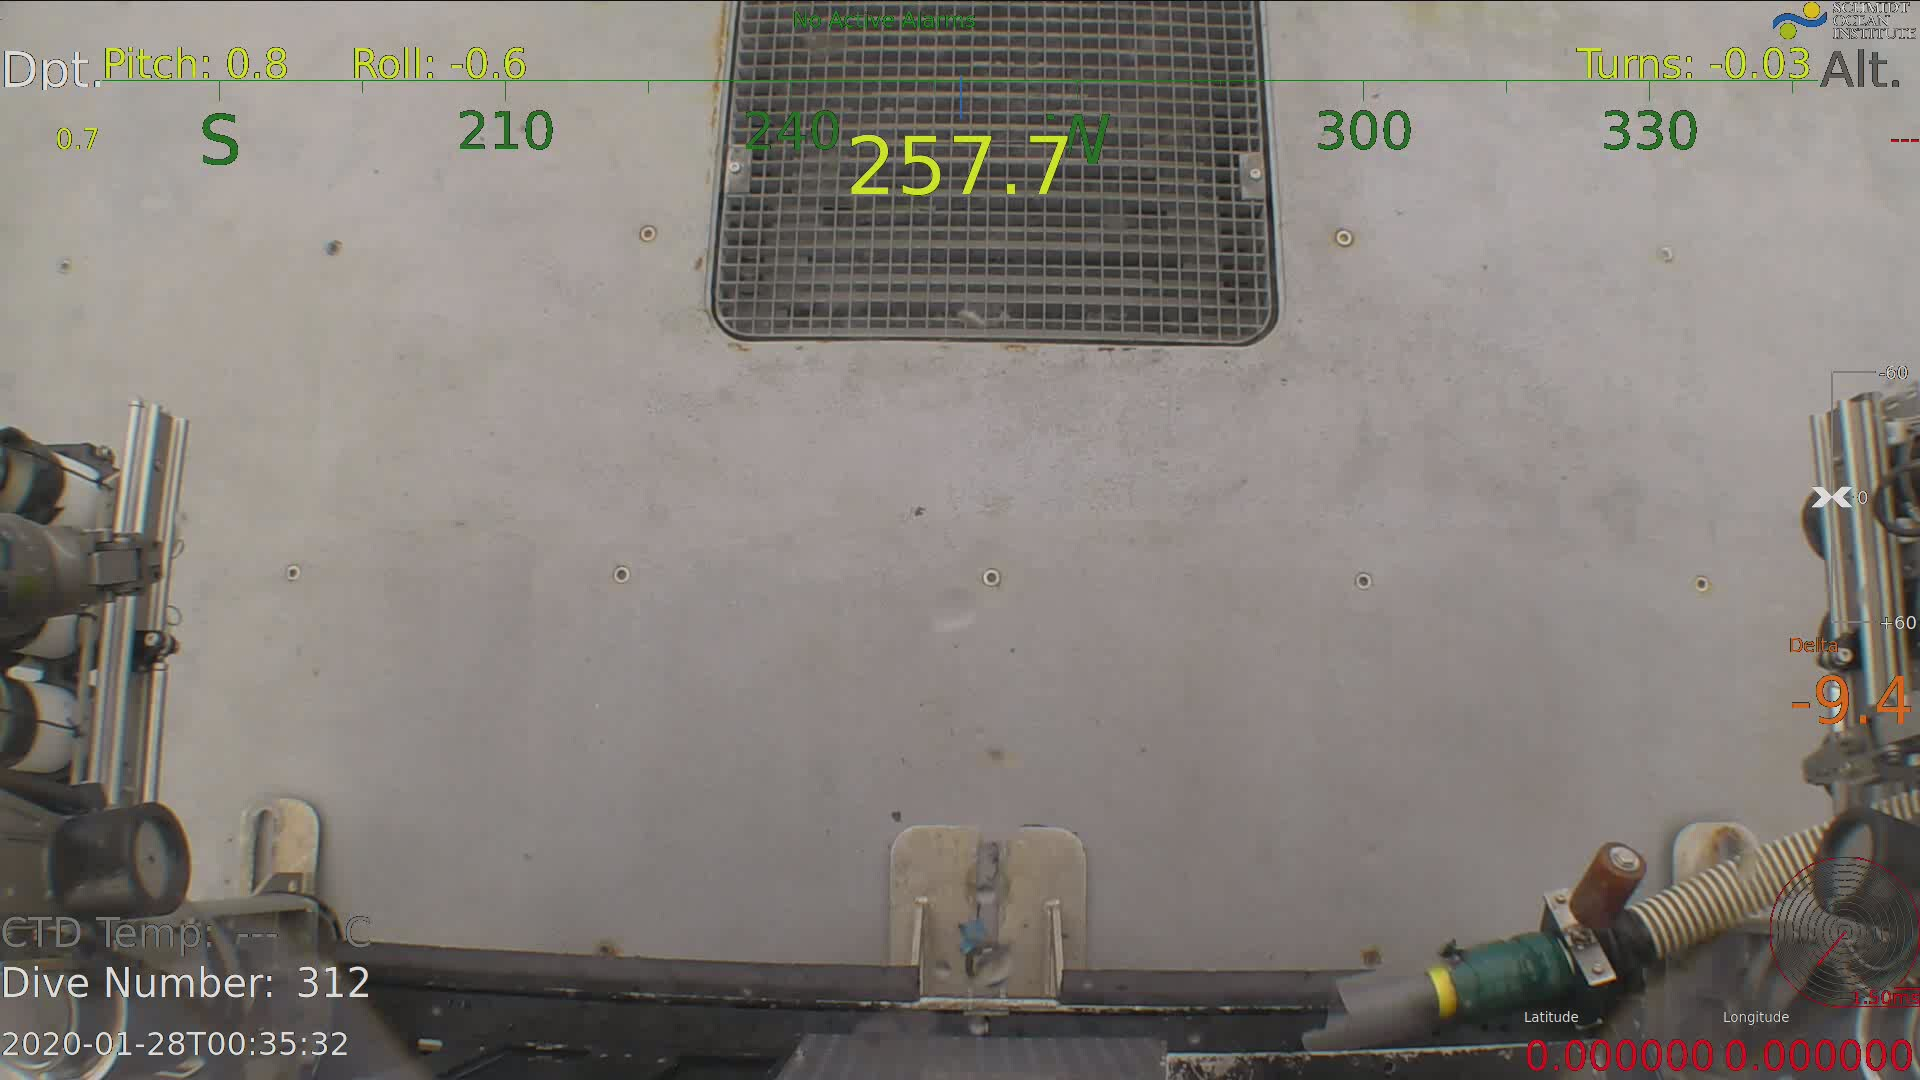

In [53]:
fnum = 0
SOI_dir.save_img(frame = frames[fnum], dive_id = soi_dive_id, output_path = dive_path, resolution=res)
from IPython.display import Image
Image(filename=f"{dive_path}SOI_{res}_{frames[fnum]}.jpeg") 

Image's shape: (1080, 1920)
Cropped Image's shape: (45, 350)


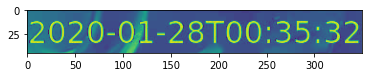

In [54]:
#Load image and print shape
img = cv2.imread(f"{dive_path}SOI_{res}_{frames[fnum]}.jpeg", 0)
print("Image's shape:", img.shape)
#Crop the image to segment where image is displayed
cropped_img = img[1020:1065, 0:350] 
#It's very important to crop as close to the numbers as possible;
#leave as little background as we can
print("Cropped Image's shape:", cropped_img.shape)
plt.imshow(cropped_img)
plt.show()

### Trying different filters and test tesseract

The parameters of all filters were tuned so that tesseract (our image extraction algorithm) is able to extract the text effectively. All filters perform fairly well; some will require RegEx to make them work, but it should be fairly simple to implement 

Text extracted in 0: 2020-0f1-28T00:35:32

Text extracted in 1: 2020-01-28T00:35:32

Text extracted in 2: 2020-Qf -28T00:35:32

Text extracted in 3: 2020-Qf-28T00:35:32

Text extracted in 4: 2020-01-28T00:35:32



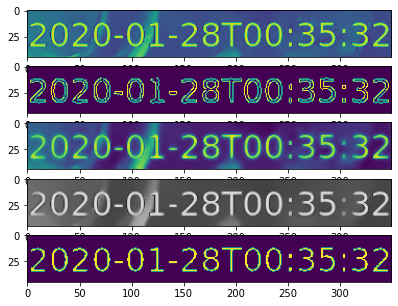

In [55]:
datetime_img = ie.Crop_SOI_image(dive_path=dive_path, res=res, soi_dive_id=soi_dive_id,
                                 fnum=1580171732, ylo=1020, yhi=1065, xlo=0, xhi=350)
#Apply filters to the image
datetime_img.apply_all_filters()
#Apply tesseract to all filtered images
datetime_img.apply_tesseract_toall(custom_config = r'--oem 3 --psm 6')

#Display
fig, ax=plt.subplots(len(datetime_img.images), 1, figsize=(10,5))

i=0
for key, img in datetime_img.images.items():
    ax[i].imshow(img)
    print(f"Text extracted in {i}: " + datetime_img.extracted_text[key])
    i = i + 1

## Apply tesseract to a random subset frames - whole datetime

In [56]:
import random
rand_frames = random.sample(frames, 2000)

ie.extract_num_from_images(rand_frames, dive_path, res, soi_dive_id,
                            ylo=1020, yhi=1065, xlo=0, xhi=350, 
                            custom_config = r'--oem 3 --psm 6',
                            verbose_each = 5000,
                            output_name='dt_extr_rand')

Iterated over frame 50
Iterated over frame 99


In [87]:
tesseract_df = pd.read_pickle(f'{dive_path}dt_extr_rand.pickle')
tesseract_df.head()
#tesseract_df = tesseract_df.drop_duplicates(subset=['frame'])

,frame,original,canny,blf,denoised,threshold
0,1580205784,2020-01-28) LOM@n. 03\n,2020-01-287T° ©.03 03\n,VAP ONeyy am Mek\n,"2020-01-281 LOM@m, 03\n",2020-01-28 PT Gen: 03\n
1,1580203151,2020-01-28T09:19:21\n,2020-01-28T09:19:11\n,2020-01-28T09:19: 50\n,2020-01-28T09:19:11\n,2020-01-28T09:19:11\n
2,1580185960,2020-01-28704:32:40\n,2020-01-281'04:32:40\n,2020-01-28104:32:40\n,2020-01-28104:32:40\n,2020-01-28T04:32:40\n
3,1580186963,2020-01-28T04:49:22\n,2020-01-28T04:49:22\n,2020-01-28T04:49:22\n,2020-01-28T04:49:22\n,2020-01-28T04:49:22\n
4,1580183557,VAoylOn ON eyssa tec Hoye wy)\n,2020-01-28T03:52:37\n,"yAepleneheys-1 che yacy,\n",2020-01-28T03:52:37\n,2020-01-28T03:52:37\n


### Create target variable

In [88]:
import datetime as dt 
init_time = dt.datetime(2020, 1,28, 0, 35, 32)
init_frame = frames[0]
target = []
for i in tesseract_df['frame']:
    target.append(init_time + dt.timedelta(seconds= (i - init_frame)))

tesseract_df['target'] = target
tesseract_df['target_time'] = [i.time() for i in target]
tesseract_df['target_hour'] = [i.time().hour for i in target]
tesseract_df['target_min'] = [i.time().minute for i in target]
tesseract_df['target_sec'] = [i.time().second for i in target]

### RegEx the extracted text

In [89]:
filters = ['original', 'canny', 'blf', 'denoised', 'threshold']
for type in filters:
    ie.extract_time_from_datetime(tesseract_df, img_type = type)

tesseract_df.sort_values(by='frame', inplace=True)
tesseract_df.tail()

,frame,original,canny,blf,denoised,threshold,target,target_time,target_hour,target_min,target_sec,original_hour,original_min,original_sec,canny_hour,canny_min,canny_sec,blf_hour,blf_min,blf_sec,denoised_hour,denoised_min,denoised_sec,threshold_hour,threshold_min,threshold_sec
716,1580207229,2020-01-28 10:27:09\n,2020-01-28T10:27:09\n,2020-01-2$ 10:27:09\n,2020-01-2$1 10:27:09\n,2020-01-28710:27:09\n,2020-01-28 10:27:09,10:27:09,10,27,9,10,27,9,10,27,9,10,27,9,10,27,9,10,27,9
1640,1580207230,2020-01-28 10:27:10\n,VIOPLOE OTM EaK®\n,2020-01-21 10:27:10\n,2020-01-21 10:27:10\n,2020-01-28T10:27:10\n,2020-01-28 10:27:10,10:27:10,10,27,10,10,27,10,,,,10,27,10,10,27,10,10,27,10
1284,1580207258,2020-01-2$1)10:2 7:38\n,2020-01-28710:27:38\n,2020-01-21 10:27:38\n,2020-01-28 10:27:38\n,2020-01-28T10:27:38\n,2020-01-28 10:27:38,10:27:38,10,27,38,,,38,10,27,38,10,27,38,10,27,38,10,27,38
495,1580207270,2020-01-28 10:27:50\n,2020-01-28 110:27:50\n,2020-01-21 10:27:50\n,2020-01-2$1 10:27:50\n,2020-01-28T10:27:50\n,2020-01-28 10:27:50,10:27:50,10,27,50,10,27,50,10,27,50,10,27,50,10,27,50,10,27,50
721,1580207322,2020-01-28 10:28:42\n,2020-01-28 110:28:42\n,2020-01-2g1 10:28:42\n,2020-01-21 10:28:42\n,2020-01-28T10:28:42\n,2020-01-28 10:28:42,10:28:42,10,28,42,10,28,42,10,28,42,10,28,42,10,28,42,10,28,42


### Get a measure of accuracy and try to improve

In [90]:
import numpy as np
for img_type in filters:
    print(img_type, 'accuracy')
    print('    Hours',  np.mean(tesseract_df[img_type + '_hour'] == tesseract_df['target_hour']))
    print('    Minutes',  np.mean(tesseract_df[img_type + '_min'] == tesseract_df['target_min']))
    tesseract_df['sec_right'] = (tesseract_df[img_type + '_sec'] == tesseract_df['target_sec'])
    for i in [-1, 1, 59]:
        tesseract_df['sec_right'][pd.to_numeric(tesseract_df[img_type + '_sec']) - tesseract_df['target_sec']==i] = True
    print('    Seconds',  np.mean(tesseract_df['sec_right']))

original accuracy
    Hours 0.571
    Minutes 0.569
    Seconds 0.7995
canny accuracy
    Hours 0.561
    Minutes 0.56
    Seconds 0.7385
blf accuracy
    Hours 0.5765
    Minutes 0.575
    Seconds 0.6635
denoised accuracy
    Hours 0.48
    Minutes 0.478
    Seconds 0.7615
threshold accuracy
    Hours 0.801
    Minutes 0.7985
    Seconds 0.899


/tmp/ipykernel_15607/1969158489.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesseract_df['sec_right'][pd.to_numeric(tesseract_df[img_type + '_sec']) - tesseract_df['target_sec']==i] = True


/tmp/ipykernel_15607/988099764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesseract_df['sec_right'][tesseract_df['threshold_sec'] - tesseract_df[target_var]==-1] = True


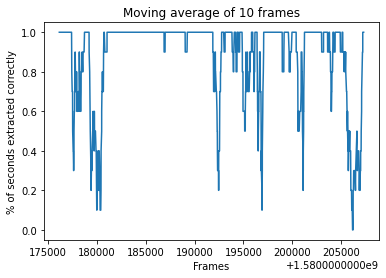

In [97]:
tesseract_df['threshold_sec'] = pd.to_numeric(tesseract_df['threshold_sec'])
tesseract_df['sec_right'] = tesseract_df['threshold_sec'] == tesseract_df['target_sec']
tesseract_df['sec_right'][tesseract_df['threshold_sec'] - tesseract_df[target_var]==-1] = True
tesseract_df['10f_rolling_avg_sec_right' ] = tesseract_df['sec_right'].rolling(10).mean()

plt.plot(tesseract_df['frame'], tesseract_df['10f_rolling_avg_sec_right' ])
plt.xlabel('Frames')
plt.ylabel('% of seconds extracted correctly')
plt.title('Moving average of 10 frames')
plt.show()

What this plot suggests is that the numbers that we extract incorrectly are clustered around very specific moments: e.g. when the line drops. This suggests that there are moments where it is difficult to get the date, and it could be due to a blurry background. However, for most of the cases, since the % doesn't drop all the way to zero, it could be that we can do some interpolation to find out what the missing numbers are. 

## Apply tesseract to a random subset frames - only seconds

Image's shape: (1080, 1920)
Cropped Image's shape: (27, 38)


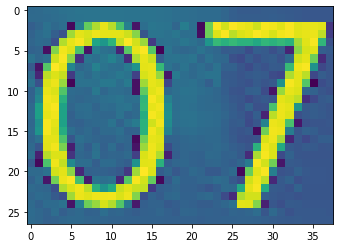

In [98]:
#Load image and print shape
img = cv2.imread(f"{dive_path}SOI_{res}_{frames[50]}.jpeg", 0)
print("Image's shape:", img.shape)
#Crop the image to segment where image is displayed
cropped_img = img[1030:1057, 310:348]
print("Cropped Image's shape:", cropped_img.shape)
plt.imshow(cropped_img)
plt.show()

In [ ]:
ie.extract_num_from_images(rand_frames, dive_path, res, soi_dive_id,
                            ylo=1030, yhi=1057, xlo=310, xhi=348, 
                            custom_config = r'--oem 3 --psm 6',
                            verbose_each = 500,
                            output_name='dt_extr_rand_sec')

In [100]:
tesseract_df = pd.read_pickle(f'{dive_path}dt_extr_rand_sec.pickle')
tesseract_df.head()

init_time = dt.datetime(2020, 1,28, 0, 35, 32)
init_frame = frames[0]
target = []
for i in tesseract_df['frame']:
    target.append(init_time + dt.timedelta(seconds= (i - init_frame)))

tesseract_df['target'] = target
tesseract_df['target_time'] = [i.time() for i in target]
tesseract_df['target_sec'] = [i.time().second for i in target]

In [101]:
filters = ['original', 'canny', 'blf', 'denoised', 'threshold']
for type in filters:
    ie.extract_sec_from_sec(tesseract_df, img_type = type)

tesseract_df.sort_values(by='frame', inplace=True)
tesseract_df.tail()

,frame,original,canny,blf,denoised,threshold,target,target_time,target_sec,original_sec,canny_sec,blf_sec,denoised_sec,threshold_sec
1814,1580207296,16\n,allie\n,16\n,16\n,16\n,2020-01-28 10:28:16,10:28:16,16,16,,16,16,16
1618,1580207301,24h\n,val\n,al\n,AT\n,val\n,2020-01-28 10:28:21,10:28:21,21,24,,,,
1929,1580207303,23\n,a.\n,Tae:\n,Tae:\n,23\n,2020-01-28 10:28:23,10:28:23,23,23,,,,23
1533,1580207338,ays:\n,S58\n,ets:\n,ets;\n,58\n,2020-01-28 10:28:58,10:28:58,58,,58,,,58
1710,1580207341,Oni\n,Onl\n,on\n,Oni\n,Ol]\n,2020-01-28 10:29:01,10:29:01,1,,,,,


In [102]:
import numpy as np
for img_type in filters:
    print(img_type, 'accuracy')
    print('    Seconds',  np.mean(tesseract_df[img_type + '_sec'] == tesseract_df['target_sec']))

original accuracy
    Seconds 0.3005
canny accuracy
    Seconds 0.0575
blf accuracy
    Seconds 0.2555
denoised accuracy
    Seconds 0.291
threshold accuracy
    Seconds 0.2185


Accuracy falls when we focus on seconds only, we should probably stick to capturing datetime. 